In [1]:
from citrination_client import CitrinationClient
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
from saxskit import saxs_fit, saxs_math
from saxskit.saxs_citrination import CitrinationSaxsModels

## Predict populations and scattering parameters using the Citrination platform

#### Step 1. Read q (1/A) and Intensity from csv file

In [3]:
p = os.getcwd()
d, _  = os.path.split(p)
path = os.path.join(d,'examples','sample_0.csv')

q_I = np.genfromtxt (path, delimiter=",")

#### Step 2. Examine the spectrum

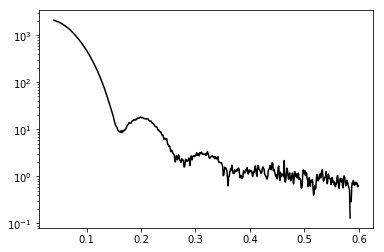

In [4]:
plt.semilogy(q_I[:,0],q_I[:,1],'-k')
plt.show()

#### Step 3. Calculate numerical features (profile) of the spectrum

In [5]:
features = saxs_math.profile_spectrum(q_I)
features

OrderedDict([('Imax_over_Imean', 13.181053776872366),
             ('Imax_sharpness', 1.0200591262893703),
             ('I_fluctuation', 0.0010389964263103481),
             ('logI_fluctuation', 5.9430730571972088),
             ('logI_max_over_std', 3.2213864774189336),
             ('r_fftIcentroid', 0.10056978331899331),
             ('r_fftImax', 0.0017857142857142857),
             ('q_Icentroid', 0.071982047474586974),
             ('q_logIcentroid', 0.13005159629922175),
             ('pearson_q', -0.55991024447800586),
             ('pearson_q2', -0.41978848602666091),
             ('pearson_expq', -0.51884676634956572),
             ('pearson_invexpq', 0.60128004622986864)])

#### Step 4. Create SaxsCitrination using Citrination credentials

In [6]:
p = os.getcwd()
d, _  = os.path.split(p)
api_key_file = os.path.join(d, 'api_key.txt')
if not os.path.exists(api_key_file):
    print("Citrination api key file did not find")
    
saxs_models = CitrinationSaxsModels(api_key_file,'https://slac.citrination.com')    

#### Step 5.  Predict scatterer populations

In [7]:
populations, uncertainties = saxs_models.classify(features)
print("-----scatterer populations:----- ")
for k,v in populations.items():
    print(k, ":", v, "  with uncertainties: %1.3f" % (uncertainties[k]))
print()

-----scatterer populations:----- 
unidentified : 0   with uncertainties: 0.008
guinier_porod : 0   with uncertainties: 0.034
spherical_normal : 1   with uncertainties: 0.005
diffraction_peaks : 0   with uncertainties: 0.010



The Citrination models predict that the data are identifiable with uncertainty 0.007 and that the scatterers include one population of a normal size distribution of spherical scatterers with uncertainty 0.008. There is not a significant Guinier-Porod-like contribution with uncertainty 0.050 and there are no diffraction peaks with uncertainty 0.006. 

The jackknife method is used for calculating of uncertainty.

#### Step 5. Predict scattering parameters

In [8]:
params,uncertainties = saxs_models.predict_params(populations, features, q_I)
print('-----scattering parameters:-----')
for k,v in params.items():
    print(k, ":", end="")
    for n in v:
        print(" %10.3f" % (n), " +/- %1.3f" % (uncertainties[k]))
print()

-----scattering parameters:-----
r0_sphere :     28.056  +/- 0.907
sigma_sphere :      0.095  +/- 0.087



The Citrination models predict the mean sphere size to be 28.056 + /- 0.907 Angstrom with fractional standard deviation of 0.095 + /- 0.087.

Parameters related to intensity (the intensities of the noise floor and spherical scattering) are now computed by constrained least-squares fitting:

In [9]:
sxf = saxs_fit.SaxsFitter(q_I,populations)
params, report = sxf.fit_intensity_params(params)
print('-----scattering and intensity parameters:-----')
for k,v in params.items():
    print(k, ":", end="")
    for n in v:
        print(" %10.3f" % (n))

-----scattering and intensity parameters:-----
I0_floor :      0.540
I0_sphere :   3202.553
r0_sphere :     28.056
sigma_sphere :      0.095


#### Step 6. Evaluate the predicted spectrum

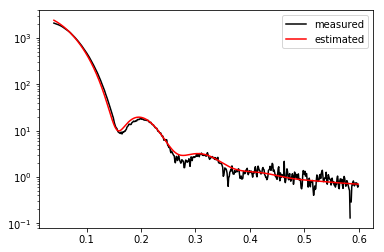

In [10]:
I_estimate = saxs_math.compute_saxs(q_I[:,0],populations,params)
plt.semilogy(q_I[:,0],q_I[:,1],'-k')
plt.semilogy(q_I[:,0],I_estimate,'-r')
plt.legend(['measured','estimated'])
plt.show()

#### Step 7. Least-squares fit the spectrum

In [11]:
params_opt, rpt = sxf.fit(params)
for k,v in params_opt.items():
    print(k, ":", end="")
    for n in v:
        print(" %10.3f" % (n))

I0_floor :      0.528
I0_sphere :   2950.849
r0_sphere :     27.407
sigma_sphere :      0.088


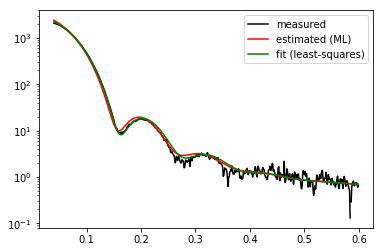

In [12]:
I_opt = saxs_math.compute_saxs(q_I[:,0],populations,params_opt)
plt.semilogy(q_I[:,0],q_I[:,1],'-k')
plt.semilogy(q_I[:,0],I_estimate,'-r')
plt.semilogy(q_I[:,0],I_opt,'-g')
plt.legend(['measured','estimated (ML)','fit (least-squares)'])
plt.show()